In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('mbti_1.csv')

In [3]:
df.head(4)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."


In [4]:
df.columns

Index(['type', 'posts'], dtype='object')

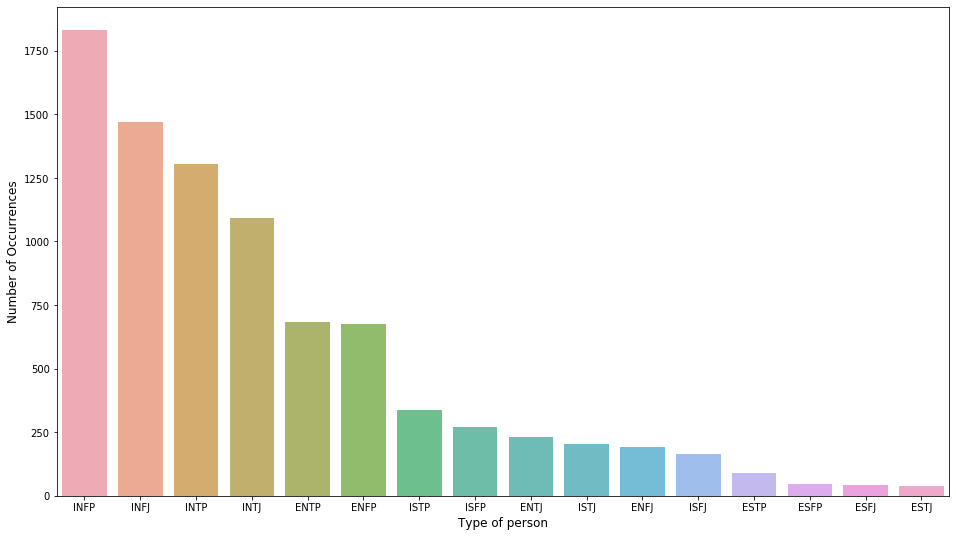

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
type_count = df['type'].value_counts()

plt.figure(figsize=(16,9))
sns.barplot(type_count.index, type_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of person', fontsize=12)
plt.show()

In [6]:
##any missing value?
df.isnull().sum()

type     0
posts    0
dtype: int64

In [13]:
import random
import nltk,re,string
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def combine_text(text):
    return ' '.join(text)

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punc = clean_text(text)
    tokenized_text = tokenizer.tokenize(no_punc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = combine_text(remove_stopwords)
    
    return combined_text

In [14]:
df['clean_posts'] = df['posts'].apply(lambda x: text_preprocessing(x))


In [15]:
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
df['description'] = df.type.apply(lambda x:' '.join([mbti[l] for l in list(x)]))
df['clean_text_length'] = df.clean_posts.apply(lambda x:len(x))

In [46]:
from wordcloud import WordCloud
def Word_Cloud(dataset , category):
    fig , ax1 = plt.subplots(1 , 1 , figsize = [26,8])
    dx = dataset[dataset.type == category]['clean_posts']
    wordcloud1 = WordCloud(background_color = 'white' , width = 600 , height = 400).generate(" ".join(dx))
    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Wordcloud for posts '+ category , fontsize = 20)

In [47]:
types = df.type.unique()
type_plot = types[1:4]
type_plot

array(['ENTP', 'INTP', 'INTJ'], dtype=object)

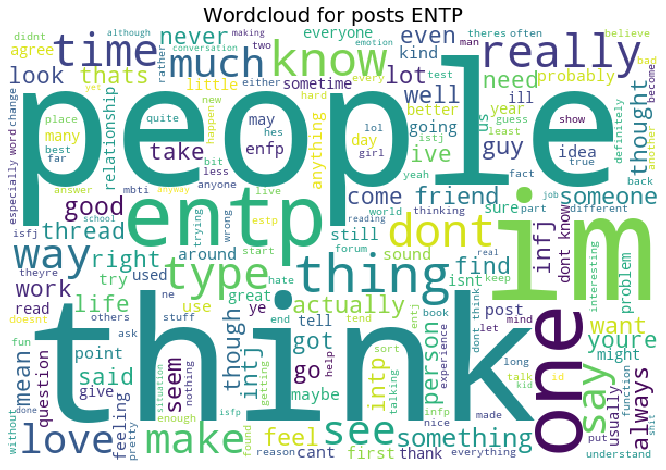

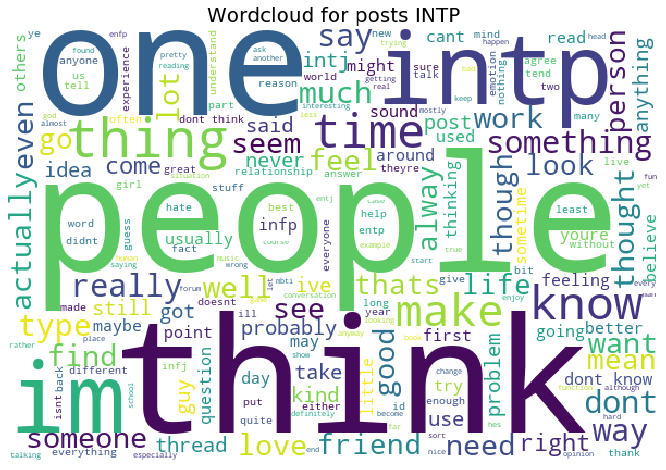

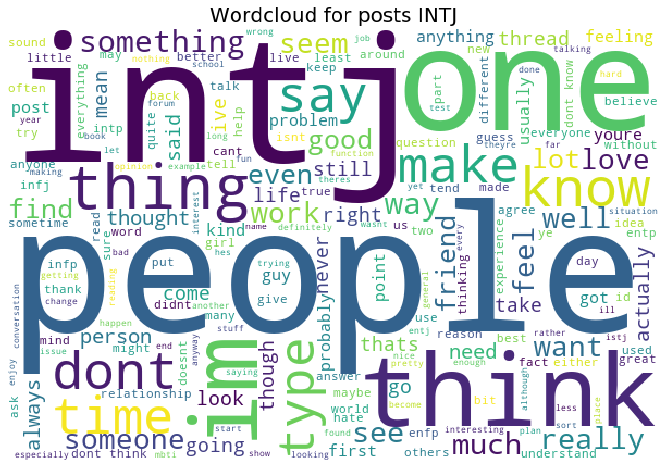

In [48]:
for i in type_plot:
    Word_Cloud(df,i)

In [26]:
from sklearn.preprocessing import LabelEncoder
dx = df[['clean_posts','type']]
encoder = LabelEncoder()
dx['type_enc'] = encoder.fit_transform(dx.type)
dx.head()

/Users/nbhadra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,clean_posts,type,type_enc
0,intj moments sportscenter top ten plays pranks...,INFJ,8
1,im finding lack posts alarmingsex boring posit...,ENTP,3
2,good one course say know thats blessing cursed...,INTP,11
3,dear intp enjoyed conversation day esoteric ga...,INTJ,10
4,youre firedthats another silly misconception a...,ENTJ,2


In [27]:
category = list(encoder.classes_)

In [28]:
train_data = dx.iloc[:6940,:]
test_data = dx.iloc[6940:,]
train_data.shape,test_data.shape

((6940, 3), (1735, 3))

In [29]:
train_data.isnull().sum()

clean_posts    0
type           0
type_enc       0
dtype: int64

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_data.clean_posts)
test_vectors = count_vectorizer.transform(test_data.clean_posts)

In [33]:
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1 , 2))
train_tfidf = tfidf_vectorizer.fit_transform(train_data.clean_posts)
test_tfidf = tfidf_vectorizer.transform(test_data.clean_posts)

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced' , C = 0.005)
score =cross_val_score(clf , train_vectors , train_data['type_enc'] , cv = 5 , scoring = 'f1_micro')
score

/Users/nbhadra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/nbhadra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

array([0.620317  , 0.6426513 , 0.63688761, 0.64769452, 0.63544669])

In [37]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(max_depth = 7 , n_estimators = 200 , colsample_bytree = 0.8 , subsample = 0.8 , nthread = 10 , learning_rate = 0.1)
scores = cross_val_score(clf_xgb , train_vectors , train_data['type_enc'] , cv = 5 , scoring = 'f1_micro')
scores

array([0.64337176, 0.6592219 , 0.65994236, 0.66498559, 0.62608069])

In [38]:
clf_xgb.fit(train_vectors , train_data.type_enc)
y_pred = clf_xgb.predict(test_vectors)
y_test = test_data.type_enc
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.654178674351585

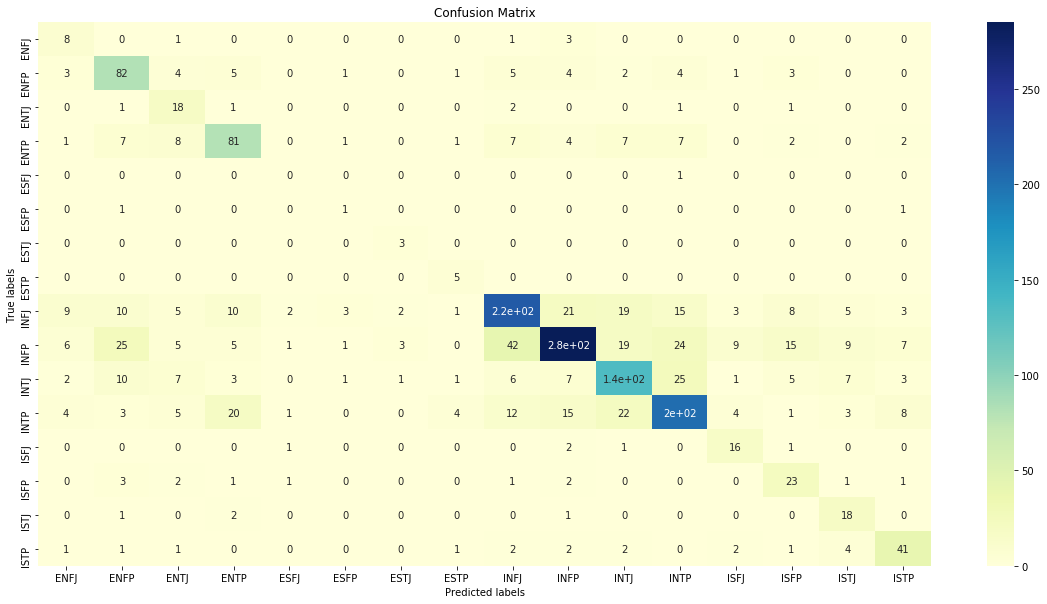

In [41]:
from sklearn.metrics import confusion_matrix
clf_xgb.predict(test_vectors)
cm = confusion_matrix(y_pred,y_test)
plt.figure(figsize = (20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(category); ax.yaxis.set_ticklabels(category);
